In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os,glob
from os import listdir,makedirs
from os.path import isfile,join
from tqdm import tqdm
import random
from sklearn.model_selection import KFold
import statistics as st


test_dir = '/content/drive/MyDrive/test'
catagories = []
for c in os.listdir(test_dir):
    catagories.append(c)
print(catagories)

['ship', 'horse', 'frog', 'automobile', 'bird', 'dog', 'deer', 'truck', 'airplane', 'cat']


In [21]:
from numpy.ma import test
test_data = []
for c in catagories:
    path = os.path.join(test_dir, c)
    label = catagories.index(c)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img_arr = cv2.resize(img_arr, (32, 32))
        test_data.append([img_arr, label])

print(f"Total Test Data: {len(test_data)}")

100%|██████████| 1000/1000 [00:02<00:00, 347.31it/s]


Total Test Data: 10000


In [ ]:
random.shuffle(test_data)

KFactor = [0.25, 0.5, 1, 2, 4]
kf = KFold(n_splits=5, random_state=None, shuffle=False)
for i,(train_index, test_index) in enumerate(kf.split(test_data)):
    k_values = np.multiply(np.sqrt(train_index.size),KFactor)
    # k_values = np.arange(1,np.sqrt(train_index.size)*10,40)
    k_values = [int(x) for x in k_values]
    break

In [22]:
accuracy = np.zeros((2,len(k_values),kf.n_splits), dtype=int)

res = []
for i,(train_index, test_index) in enumerate(kf.split(test_data)):
    for x in tqdm(test_index):
        r = []
        testData = test_data[x][0]
        l1 = []
        l2 = []
        for y in train_index:
            trainData = test_data[y][0]
            d = np.sum(abs(testData-trainData))
            l1.append(d)
            d = np.sqrt(np.sum((testData-trainData)**2))
            l2.append(d)
        l1_i = np.argsort(l1)
        l2_i = np.argsort(l2)
        for k in k_values:
            comp = []
            for j in l1_i[:k]:
                comp.append(test_data[j][1])
            if st.mode(comp) == test_data[x][1]:
                accuracy[0][k_values.index(k)][i] += 1
            comp = []
            for j in l2_i[:k]:
                comp.append(test_data[j][1])
            if st.mode(comp) == test_data[x][1]:
                accuracy[1][k_values.index(k)][i] += 1

100%|██████████| 2000/2000 [05:46<00:00,  5.77it/s]


In [18]:
L1_acc = [[],[]]
L2_acc = [[],[]]
print(accuracy)
for a in accuracy[0]:
    L1_acc[0].append(a.mean()*100/2000)
    L1_acc[1].append(a.std()*100/2000)
for a in accuracy[1]:
    L2_acc[0].append(a.mean()*100/2000)
    L2_acc[1].append(a.std()*100/2000)

[[[188 323 396 438 450]
  [208 349 418 441 452]
  [189 350 409 427 436]
  [203 363 402 418 432]
  [187 366 382 392 412]]

 [[192 288 310 305 302]
  [200 293 306 297 291]
  [198 290 301 289 285]
  [176 281 299 307 296]
  [193 280 308 321 316]]]


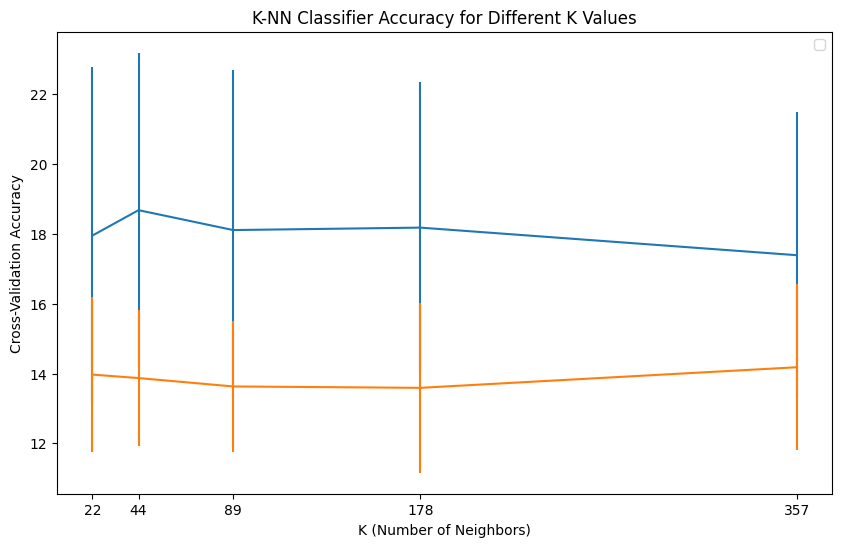

In [19]:
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, L1_acc[0], L1_acc[1])
plt.errorbar(k_values, L2_acc[0], L2_acc[1])
plt.legend(['Manhattan (L1)','Euclidean (L2)'])
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('K-NN Classifier Accuracy for Different K Values')
plt.xticks(k_values)
plt.legend()
plt.show()